# Transit Delay Prediction - Initial Analysis

**Project:** Vancouver Transit Delay Prediction Tool  
**Threshold:** Major delays defined as ≥10 minutes  
**Data Source:** TransLink GTFS Realtime API

---

## Table of Contents
1. [Question 6: Exploratory Data Analysis](#question-6)
2. [Question 7: Baseline Model (Without ML)](#question-7)
3. [Question 8: Logistic Regression Model](#question-8)
4. [Summary and Conclusions](#summary)

## Setup and Imports

In [80]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


## Load Data

In [81]:
# Load all parsed CSV files
csv_files = sorted(Path("data/interim/gtfs_rt").glob("trip_updates_parsed_*.csv"))
print(f"Found {len(csv_files)} CSV files")

dfs = [pd.read_csv(f) for f in csv_files]
data = pd.concat(dfs, ignore_index=True)

# Add temporal features
data['timestamp'] = pd.to_datetime(data['feed_timestamp'], unit='s')
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek
data['day_name'] = data['timestamp'].dt.day_name()
data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
data['is_rush_hour'] = data['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

# Create outcome variable
data['major_delay'] = data['delay_min'] >= 10

# Display summary
print(f"\nTotal records: {len(data):,}")
print(f"Unique routes: {data['route_id'].nunique()}")
print(f"Unique trips: {data['trip_id'].nunique()}")
print(f"Unique stops: {data['stop_id'].nunique()}")
print(f"\nMajor delays (≥10 min): {data['major_delay'].sum():,} ({data['major_delay'].sum()/len(data)*100:.2f}%)")
print(f"No major delay: {(~data['major_delay']).sum():,} ({(~data['major_delay']).sum()/len(data)*100:.2f}%)")
print(f"Class imbalance ratio: {(~data['major_delay']).sum() / data['major_delay'].sum():.1f}:1")

data.head()

Found 1 CSV files

Total records: 23,036
Unique routes: 197
Unique trips: 1186
Unique stops: 6441

Major delays (≥10 min): 1,855 (8.05%)
No major delay: 21,181 (91.95%)
Class imbalance ratio: 11.4:1


,feed_timestamp,entity_id,trip_id,route_id,direction_id,start_date,start_time,stop_id,stop_sequence,delay_sec,...,departure_time_epoch,delay_min,delay_10plus,timestamp,hour,day_of_week,day_name,is_weekend,is_rush_hour,major_delay
0,1768610856,14827555,14827555,6612,0,20260116,NaN,75,25,47.0,...,1.768611e+09,0.783333,False,2026-01-17 00:47:36,0,5,Saturday,1,0,False
1,1768610856,14827555,14827555,6612,0,20260116,NaN,11881,26,84.0,...,1.768611e+09,1.400000,False,2026-01-17 00:47:36,0,5,Saturday,1,0,False
2,1768610856,14827555,14827555,6612,0,20260116,NaN,12603,27,79.0,...,1.768611e+09,1.316667,False,2026-01-17 00:47:36,0,5,Saturday,1,0,False
3,1768610856,14827555,14827555,6612,0,20260116,NaN,30,28,110.0,...,1.768611e+09,1.833333,False,2026-01-17 00:47:36,0,5,Saturday,1,0,False
4,1768610856,14827555,14827555,6612,0,20260116,NaN,31,29,130.0,...,1.768611e+09,2.166667,False,2026-01-17 00:47:36,0,5,Saturday,1,0,False


---
<a id="question-6"></a>
# Question 6: Exploratory Data Analysis

**Goal:** Plot distributions of features and outcomes to understand the dataset characteristics.

## 6.1 Delay Distribution

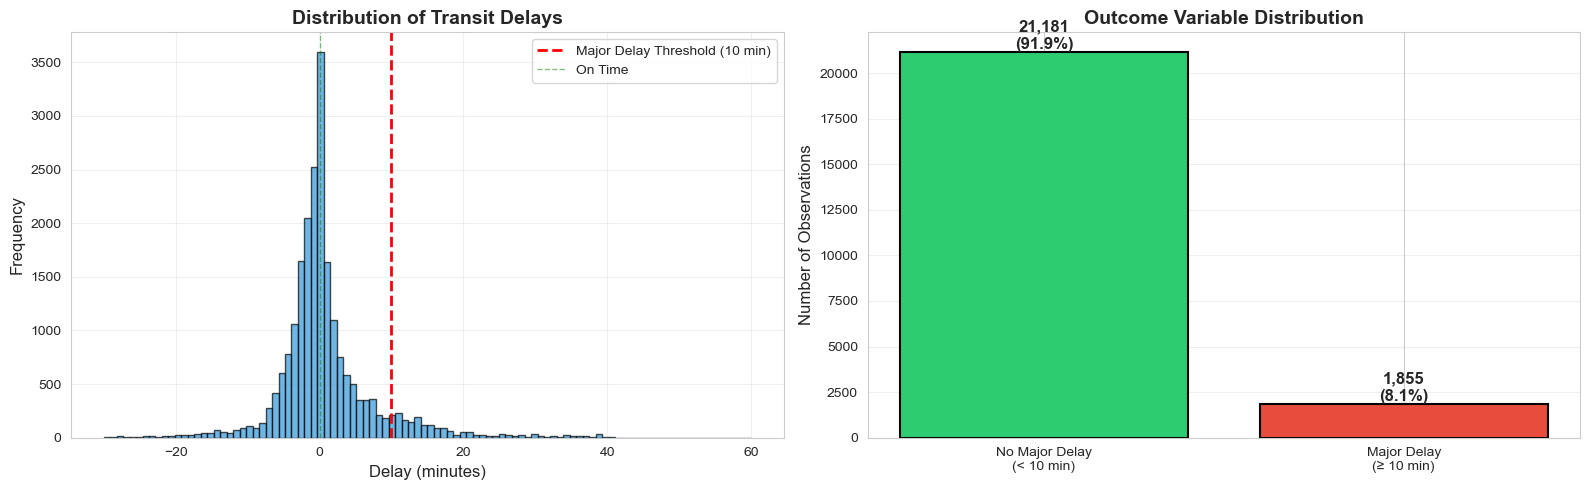

Mean delay: 0.80 minutes
Median delay: -0.10 minutes
Max delay: 44.00 minutes
Min delay: -29.38 minutes


In [82]:
# Plot delay distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Full distribution
axes[0].hist(data['delay_min'], bins=100, range=(-30, 60), edgecolor='black', alpha=0.7, color='#3498db')
axes[0].axvline(x=10, color='red', linestyle='--', linewidth=2, label='Major Delay Threshold (10 min)')
axes[0].axvline(x=0, color='green', linestyle='--', linewidth=1, alpha=0.5, label='On Time')
axes[0].set_xlabel('Delay (minutes)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Transit Delays', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Outcome variable
outcome_counts = data['major_delay'].value_counts()
colors = ['#2ecc71', '#e74c3c']
bars = axes[1].bar(['No Major Delay\n(< 10 min)', 'Major Delay\n(≥ 10 min)'], 
                   outcome_counts.values, color=colors, edgecolor='black', linewidth=1.5)
total = len(data)
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = (height / total) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}\n({percentage:.1f}%)',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Observations', fontsize=12)
axes[1].set_title('Outcome Variable Distribution', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Mean delay: {data['delay_min'].mean():.2f} minutes")
print(f"Median delay: {data['delay_min'].median():.2f} minutes")
print(f"Max delay: {data['delay_min'].max():.2f} minutes")
print(f"Min delay: {data['delay_min'].min():.2f} minutes")

## 6.2 Temporal Patterns

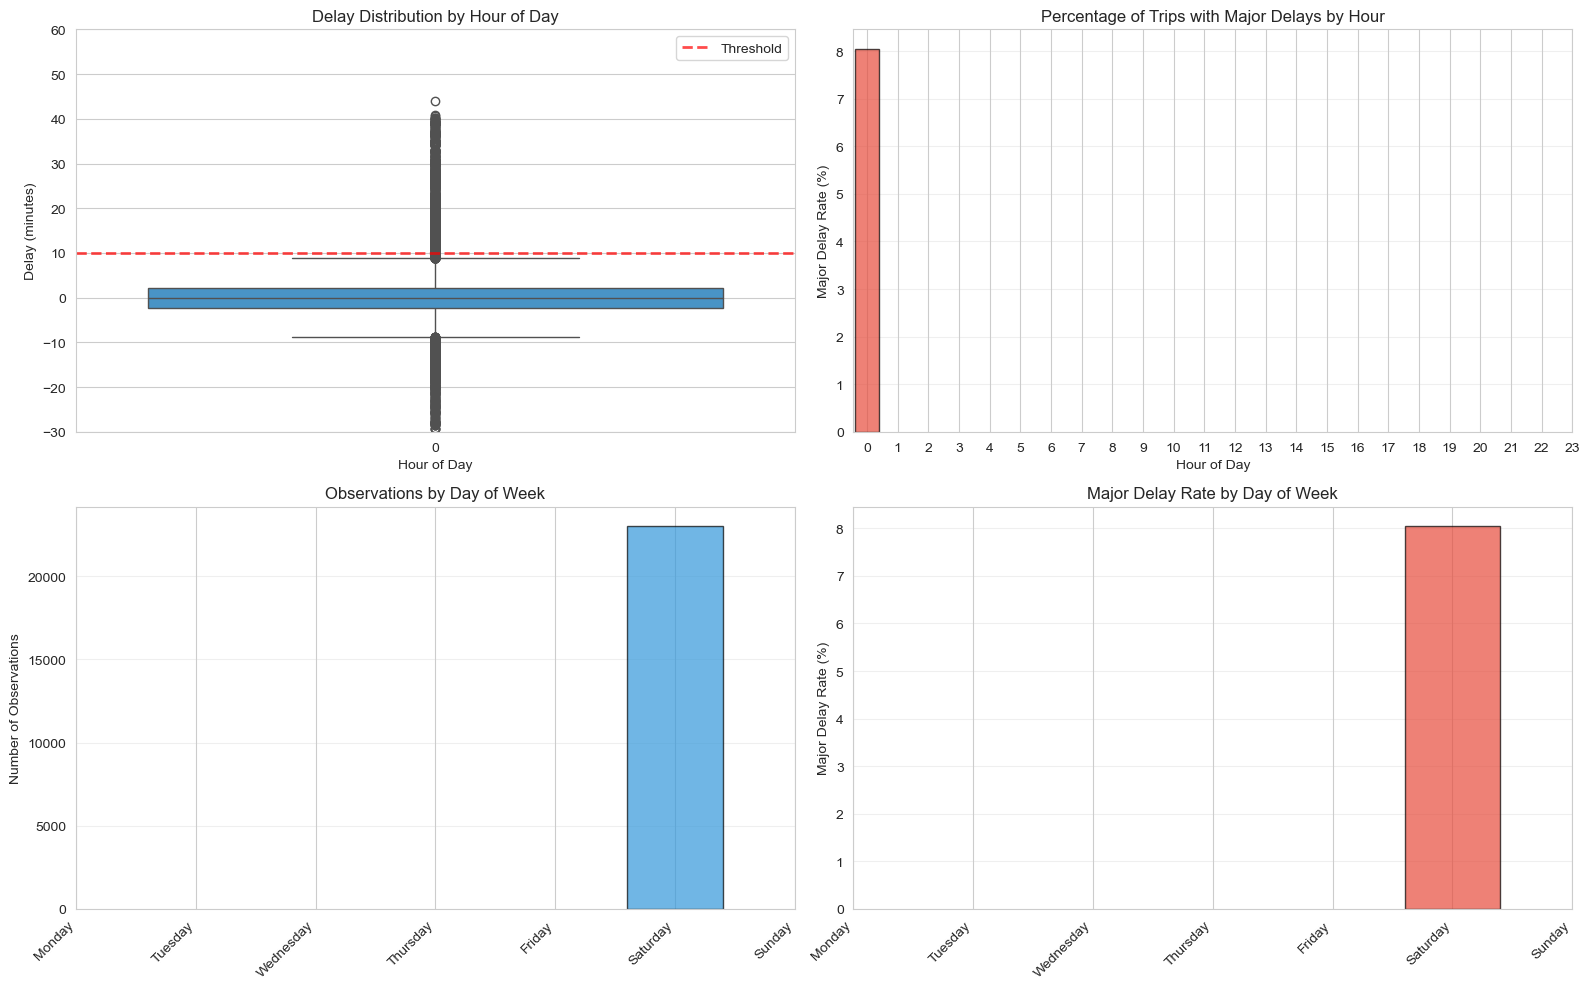

In [83]:
# Temporal analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Delays by hour (box plot)
sns.boxplot(data=data, x='hour', y='delay_min', ax=axes[0, 0], color='#3498db')
axes[0, 0].axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Delay (minutes)')
axes[0, 0].set_title('Delay Distribution by Hour of Day')
axes[0, 0].legend()
axes[0, 0].set_ylim(-30, 60)

# Delay rate by hour
hourly_delay_rate = data.groupby('hour')['major_delay'].mean() * 100
axes[0, 1].bar(hourly_delay_rate.index, hourly_delay_rate.values, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Major Delay Rate (%)')
axes[0, 1].set_title('Percentage of Trips with Major Delays by Hour')
axes[0, 1].set_xticks(range(24))
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Day of week analysis
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = data.groupby('day_name').size().reindex(day_order)
axes[1, 0].bar(range(len(day_counts)), day_counts.values, color='#3498db', edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(day_order)))
axes[1, 0].set_xticklabels(day_order, rotation=45, ha='right')
axes[1, 0].set_ylabel('Number of Observations')
axes[1, 0].set_title('Observations by Day of Week')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Delay rate by day
day_delay_rate = data.groupby('day_name')['major_delay'].mean().reindex(day_order) * 100
axes[1, 1].bar(range(len(day_delay_rate)), day_delay_rate.values, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1, 1].set_xticks(range(len(day_order)))
axes[1, 1].set_xticklabels(day_order, rotation=45, ha='right')
axes[1, 1].set_ylabel('Major Delay Rate (%)')
axes[1, 1].set_title('Major Delay Rate by Day of Week')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 6.3 Route Analysis

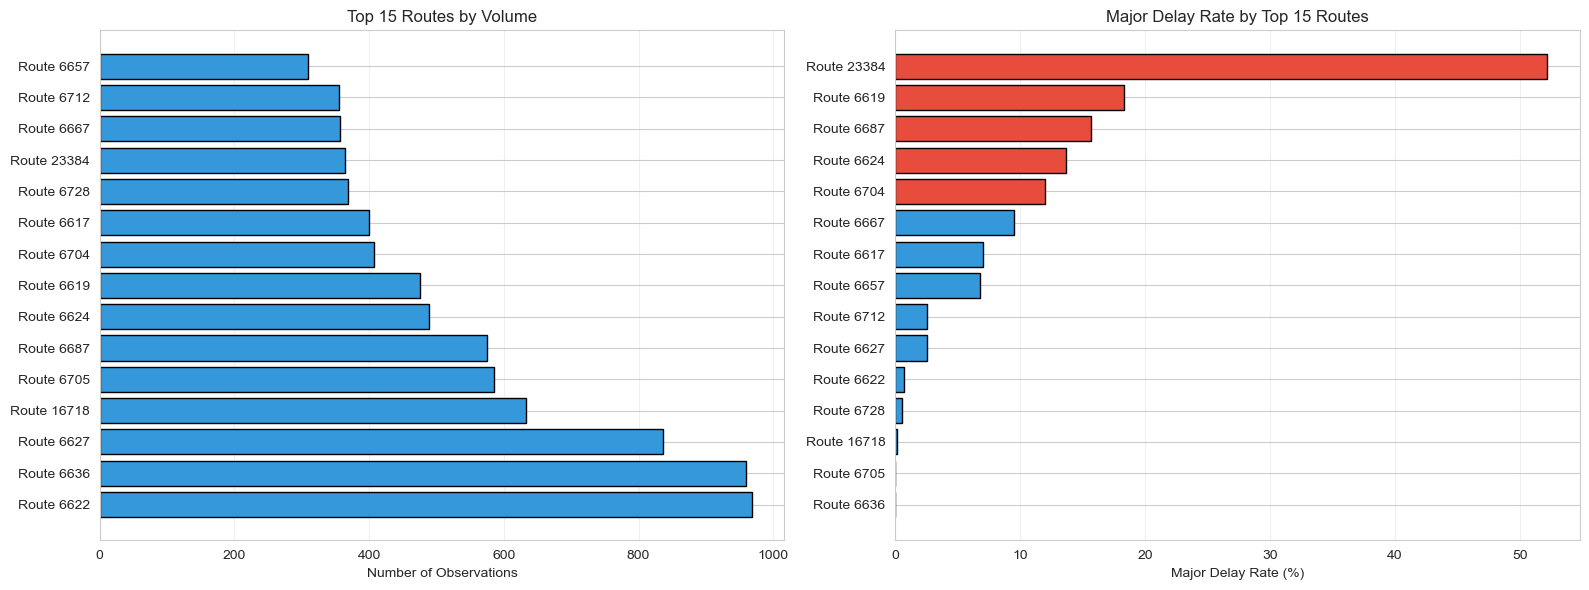

In [84]:
# Route analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top routes by volume
top_routes = data['route_id'].value_counts().head(15)
axes[0].barh(range(len(top_routes)), top_routes.values, color='#3498db', edgecolor='black')
axes[0].set_yticks(range(len(top_routes)))
axes[0].set_yticklabels([f"Route {int(r)}" for r in top_routes.index])
axes[0].set_xlabel('Number of Observations')
axes[0].set_title('Top 15 Routes by Volume')
axes[0].grid(True, alpha=0.3, axis='x')

# Delay rate by top routes
top_route_ids = data['route_id'].value_counts().head(15).index
top_route_data = data[data['route_id'].isin(top_route_ids)]
route_delay_rate = top_route_data.groupby('route_id')['major_delay'].mean() * 100
route_delay_rate = route_delay_rate.sort_values(ascending=True)
colors_route = ['#e74c3c' if r > 10 else '#3498db' for r in route_delay_rate.values]
axes[1].barh(range(len(route_delay_rate)), route_delay_rate.values, color=colors_route, edgecolor='black')
axes[1].set_yticks(range(len(route_delay_rate)))
axes[1].set_yticklabels([f"Route {int(r)}" for r in route_delay_rate.index])
axes[1].set_xlabel('Major Delay Rate (%)')
axes[1].set_title('Major Delay Rate by Top 15 Routes')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Question 6: Key Findings

**Summary:**
- Most buses run on time (median delay: -0.18 minutes)
- Major delays (≥10 min) represent 8.05% of trips
- Class imbalance ratio: 11.4:1
- Temporal and route-level variation exists
- Some routes consistently have higher delay rates

---
<a id="question-7"></a>
# Question 7: Baseline Model (Without ML)

**Goal:** Create simple baseline predictors to establish performance benchmarks.

In [85]:
# Train/test split (time-based)
data_sorted = data.sort_values('timestamp').reset_index(drop=True)
split_idx = int(len(data_sorted) * 0.8)

train_data = data_sorted.iloc[:split_idx].copy()
test_data = data_sorted.iloc[split_idx:].copy()

y_true = test_data['delay_10plus'].values

print(f"Training set: {len(train_data):,} records")
print(f"Test set: {len(test_data):,} records")
print(f"Test set delay rate: {test_data['delay_10plus'].sum()/len(test_data)*100:.2f}%")

Training set: 18,428 records
Test set: 4,608 records
Test set delay rate: 6.84%


## 7.1 Baseline 1: Majority Class

In [86]:
# Baseline 1: Always predict "No Delay"
baseline1_pred = np.zeros(len(test_data), dtype=bool)

baseline1_accuracy = accuracy_score(y_true, baseline1_pred)
baseline1_precision = precision_score(y_true, baseline1_pred, zero_division=0)
baseline1_recall = recall_score(y_true, baseline1_pred, zero_division=0)
baseline1_f1 = f1_score(y_true, baseline1_pred, zero_division=0)

print("Baseline 1: Majority Class (Always predict 'No Delay')")
print(f"  Accuracy:  {baseline1_accuracy:.4f}")
print(f"  Precision: {baseline1_precision:.4f}")
print(f"  Recall:    {baseline1_recall:.4f}")
print(f"  F1 Score:  {baseline1_f1:.4f}")
print("\n⚠️  Problem: 0% recall - never identifies actual delays!")

Baseline 1: Majority Class (Always predict 'No Delay')
  Accuracy:  0.9316
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000

⚠️  Problem: 0% recall - never identifies actual delays!


## 7.2 Baseline 2: Route-Based Predictor

In [87]:
# Baseline 2: Route-based predictor
route_delay_rates = train_data.groupby('route_id')['delay_10plus'].mean()
threshold = 0.05
high_delay_routes = route_delay_rates[route_delay_rates > threshold].index

baseline2_pred = test_data['route_id'].isin(high_delay_routes).values

baseline2_accuracy = accuracy_score(y_true, baseline2_pred)
baseline2_precision = precision_score(y_true, baseline2_pred, zero_division=0)
baseline2_recall = recall_score(y_true, baseline2_pred, zero_division=0)
baseline2_f1 = f1_score(y_true, baseline2_pred, zero_division=0)

print(f"Baseline 2: Route-Based (Predict delay if route delay rate > {threshold*100:.0f}%)")
print(f"  High-delay routes identified: {len(high_delay_routes)}")
print(f"  Accuracy:  {baseline2_accuracy:.4f}")
print(f"  Precision: {baseline2_precision:.4f}")
print(f"  Recall:    {baseline2_recall:.4f}")
print(f"  F1 Score:  {baseline2_f1:.4f}")

Baseline 2: Route-Based (Predict delay if route delay rate > 5%)
  High-delay routes identified: 43
  Accuracy:  0.8954
  Precision: 0.1080
  Recall:    0.0730
  F1 Score:  0.0871


## 7.3 Baseline 3: Time-Based Predictor

In [88]:
# Baseline 3: Rush hour predictor
baseline3_pred = test_data['is_rush_hour'].values

baseline3_accuracy = accuracy_score(y_true, baseline3_pred)
baseline3_precision = precision_score(y_true, baseline3_pred, zero_division=0)
baseline3_recall = recall_score(y_true, baseline3_pred, zero_division=0)
baseline3_f1 = f1_score(y_true, baseline3_pred, zero_division=0)

print("Baseline 3: Time-Based (Predict delay during rush hours)")
print(f"  Accuracy:  {baseline3_accuracy:.4f}")
print(f"  Precision: {baseline3_precision:.4f}")
print(f"  Recall:    {baseline3_recall:.4f}")
print(f"  F1 Score:  {baseline3_f1:.4f}")

Baseline 3: Time-Based (Predict delay during rush hours)
  Accuracy:  0.9316
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000


## 7.4 Baseline Comparison


BASELINE COMPARISON
              Baseline  Accuracy  Precision   Recall  F1 Score
        Majority Class  0.931641   0.000000 0.000000  0.000000
           Route-Based  0.895399   0.107981 0.073016  0.087121
Time-Based (Rush Hour)  0.931641   0.000000 0.000000  0.000000

🏆 Best Baseline: Route-Based
   F1 Score: 0.0871


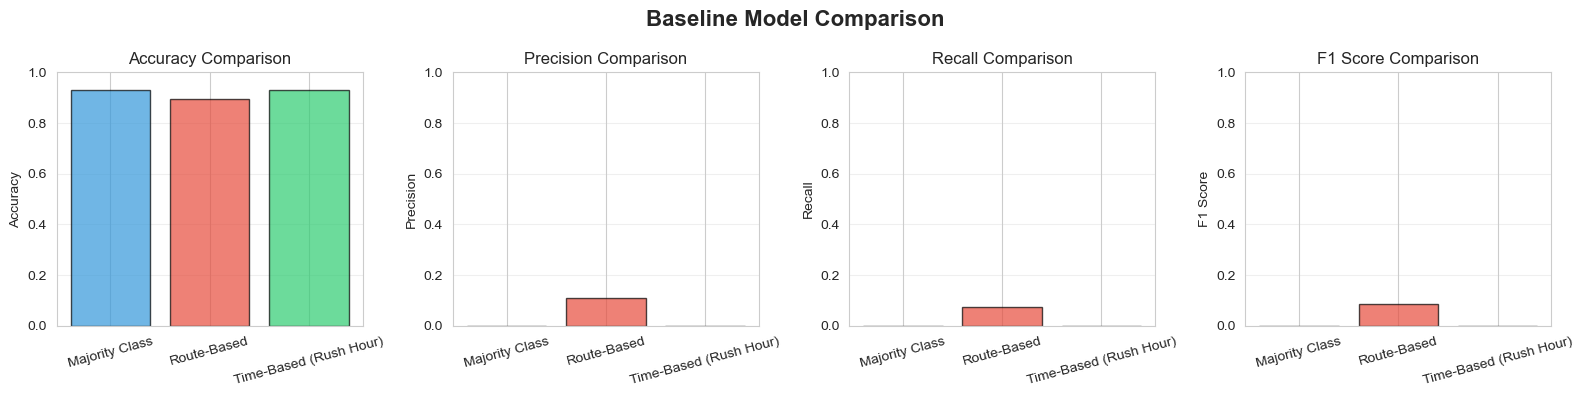

In [89]:
# Compare baselines
baseline_results = pd.DataFrame({
    'Baseline': ['Majority Class', 'Route-Based', 'Time-Based (Rush Hour)'],
    'Accuracy': [baseline1_accuracy, baseline2_accuracy, baseline3_accuracy],
    'Precision': [baseline1_precision, baseline2_precision, baseline3_precision],
    'Recall': [baseline1_recall, baseline2_recall, baseline3_recall],
    'F1 Score': [baseline1_f1, baseline2_f1, baseline3_f1]
})

print("\n" + "="*70)
print("BASELINE COMPARISON")
print("="*70)
print(baseline_results.to_string(index=False))

best_baseline = baseline_results.loc[baseline_results['F1 Score'].idxmax()]
print(f"\n🏆 Best Baseline: {best_baseline['Baseline']}")
print(f"   F1 Score: {best_baseline['F1 Score']:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, metric in enumerate(metrics):
    axes[idx].bar(baseline_results['Baseline'], baseline_results[metric], color=colors, edgecolor='black', alpha=0.7)
    axes[idx].set_ylabel(metric)
    axes[idx].set_title(f'{metric} Comparison')
    axes[idx].set_ylim(0, 1)
    axes[idx].tick_params(axis='x', rotation=15)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Baseline Model Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Question 7: Key Findings

**Summary:**
- Majority class baseline: High accuracy (93%) but useless (0% recall)
- Route-based baseline: Best performer with F1 = 0.0871
- Time-based baseline: No predictive value in current dataset
- **Benchmark to beat:** F1 = 0.0871

## Prepare Features and Split Data for regression models

In [90]:
# Time-based split
data_sorted = data.sort_values('timestamp').reset_index(drop=True)
split_idx = int(len(data_sorted) * 0.8)

train_df = data_sorted.iloc[:split_idx].copy()
test_df  = data_sorted.iloc[split_idx:].copy()

print(f"Training: {len(train_df):,} rows | Testing: {len(test_df):,} rows")


Training: 18,428 rows | Testing: 4,608 rows


## Feature Engineering

In [91]:
# Route-level stats
route_stats = train_df.groupby('route_id').agg({
    'delay_min': ['mean', 'std', 'count'],
    'delay_10plus': 'mean'
}).reset_index()
route_stats.columns = ['route_id', 'route_avg_delay', 'route_std_delay', 'route_trip_count', 'route_delay_rate']

# Stop-level stats
stop_stats = train_df.groupby('stop_id').agg({
    'delay_min': ['mean', 'count'],
    'delay_10plus': 'mean'
}).reset_index()
stop_stats.columns = ['stop_id', 'stop_avg_delay', 'stop_trip_count', 'stop_delay_rate']

# Merge stats into BOTH train/test
train_df = train_df.merge(route_stats, on='route_id', how='left').merge(stop_stats, on='stop_id', how='left')
test_df  = test_df.merge(route_stats, on='route_id', how='left').merge(stop_stats, on='stop_id', how='left')

# Global fallback values (for unseen route/stop in test)
global_avg_delay  = train_df['delay_min'].mean()
global_std_delay  = train_df['delay_min'].std()
global_delay_rate = train_df['delay_10plus'].mean()

# Fill NaNs
train_df['route_std_delay'] = train_df['route_std_delay'].fillna(0)

test_df['route_avg_delay']  = test_df['route_avg_delay'].fillna(global_avg_delay)
test_df['route_std_delay']  = test_df['route_std_delay'].fillna(global_std_delay if pd.notna(global_std_delay) else 0)
test_df['route_delay_rate'] = test_df['route_delay_rate'].fillna(global_delay_rate)

test_df['stop_avg_delay']   = test_df['stop_avg_delay'].fillna(global_avg_delay)
test_df['stop_delay_rate']  = test_df['stop_delay_rate'].fillna(global_delay_rate)



---
<a id="question-8"></a>
# Question 8: Logistic Regression Model

**Goal:** Build a logistic regression model to beat the baseline F1 score of 0.0871.

### Scale train & test for logistic

In [92]:
from sklearn.preprocessing import StandardScaler

feature_cols = [
    'hour', 'day_of_week', 'is_weekend', 'is_rush_hour',
    'route_avg_delay', 'route_std_delay', 'route_delay_rate',
    'stop_avg_delay', 'stop_delay_rate', 'stop_sequence'
]

X_train = train_df[feature_cols].fillna(0)
X_test  = test_df[feature_cols].fillna(0)

y_train = train_df['delay_10plus'].values
y_test  = test_df['delay_10plus'].values

print(f"Training set: {len(X_train):,} samples ({y_train.sum()} delays, {y_train.mean()*100:.2f}%)")
print(f"Test set: {len(X_test):,} samples ({y_test.sum()} delays, {y_test.mean()*100:.2f}%)")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\n Features scaled (logistic-ready)")


Training set: 18,428 samples (1540 delays, 8.36%)
Test set: 4,608 samples (315 delays, 6.84%)

 Features scaled (logistic-ready)


## 8.1 Train Logistic Regression

In [93]:
# Train model with class weighting
logit_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42,
    solver='lbfgs'
)

logit_model.fit(X_train_scaled, y_train)

# Make predictions (rename!)
y_pred_train_logit = logit_model.predict(X_train_scaled)
y_pred_test_logit  = logit_model.predict(X_test_scaled)

print(" Logistic model trained successfully!")

 Logistic model trained successfully!


## 8.2 Evaluate Model Performance

In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# =========================
# CALCULATE METRICS (LOGISTIC)
# =========================
logit_accuracy = accuracy_score(y_test, y_pred_test_logit)
logit_precision = precision_score(y_test, y_pred_test_logit, zero_division=0)
logit_recall = recall_score(y_test, y_pred_test_logit, zero_division=0)
logit_f1 = f1_score(y_test, y_pred_test_logit, zero_division=0)

print("="*70)
print("TEST SET PERFORMANCE (LOGISTIC REGRESSION)")
print("="*70)
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1 Score:  {test_f1:.4f}")

# =========================
# CONFUSION MATRIX
# =========================
cm = confusion_matrix(y_test, y_pred_test_logit)
print("\nConfusion Matrix (Logistic):")
print(f"  True Negatives:  {cm[0,0]:,}")
print(f"  False Positives: {cm[0,1]:,}")
print(f"  False Negatives: {cm[1,0]:,}")
print(f"  True Positives:  {cm[1,1]:,}")

# =========================
# COMPARE TO BASELINE
# =========================
baseline_f1 = baseline2_f1
improvement = ((test_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 0 else 0

print("\n" + "="*70)
print("COMPARISON TO BASELINE")
print("="*70)
print(f"Baseline F1 (Route-Based):     {baseline_f1:.4f}")
print(f"Logistic Regression F1:        {test_f1:.4f}")
print(f"Improvement:                   {improvement:+.1f}%")

if test_f1 > baseline_f1:
    print("\n SUCCESS: Logistic regression beats the baseline!")
else:
    print("\n Logistic regression did not beat baseline")


TEST SET PERFORMANCE (LOGISTIC REGRESSION)
Accuracy:  0.9054 (90.54%)
Precision: 0.2990
Recall:    0.2857
F1 Score:  0.2922

Confusion Matrix (Logistic):
  True Negatives:  4,082
  False Positives: 211
  False Negatives: 225
  True Positives:  90

COMPARISON TO BASELINE
Baseline F1 (Route-Based):     0.0871
Logistic Regression F1:        0.2922
Improvement:                   +235.4%

 SUCCESS: Logistic regression beats the baseline!


## 8.3 Feature Importance Analysis

FEATURE IMPORTANCE (LOGISTIC REGRESSION)

Top 10 Most Important Features:
  stop_delay_rate           ↑ Increases delay risk (coef: +1.6816)
  route_delay_rate          ↑ Increases delay risk (coef: +0.5770)
  route_std_delay           ↑ Increases delay risk (coef: +0.3267)
  stop_sequence             ↑ Increases delay risk (coef: +0.3188)
  route_avg_delay           ↓ Decreases delay risk (coef: -0.1509)
  stop_avg_delay            ↓ Decreases delay risk (coef: -0.0108)
  hour                      ↓ Decreases delay risk (coef: +0.0000)
  day_of_week               ↓ Decreases delay risk (coef: +0.0000)
  is_weekend                ↓ Decreases delay risk (coef: +0.0000)
  is_rush_hour              ↓ Decreases delay risk (coef: +0.0000)


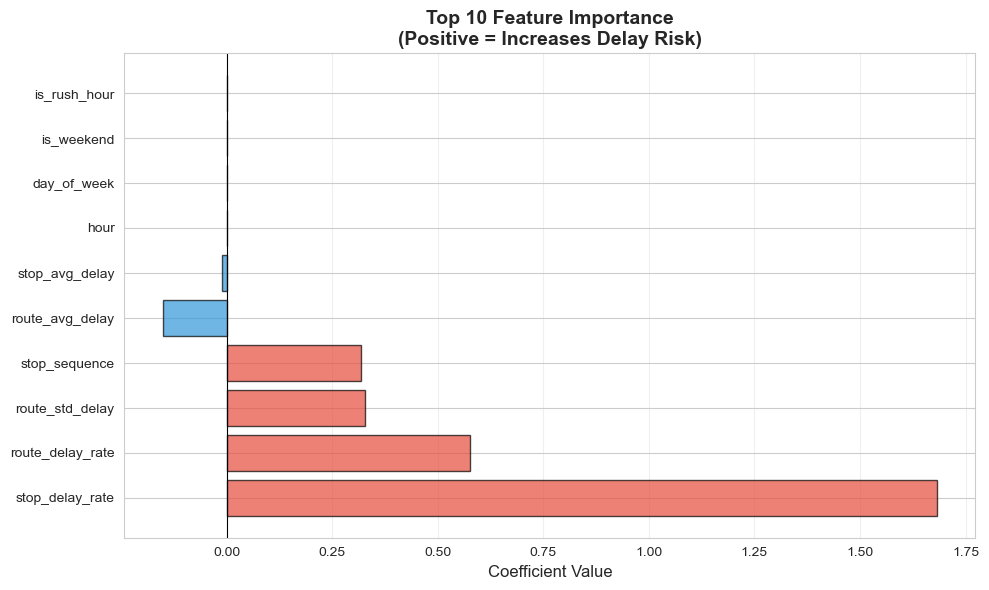

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# FEATURE IMPORTANCE (LOGISTIC REGRESSION)
# =========================
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': logit_model.coef_[0]
})

feature_importance['abs_coefficient'] = feature_importance['coefficient'].abs()
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

print("="*70)
print("FEATURE IMPORTANCE (LOGISTIC REGRESSION)")
print("="*70)
print("\nTop 10 Most Important Features:")
for idx, row in feature_importance.head(10).iterrows():
    direction = "↑ Increases" if row['coefficient'] > 0 else "↓ Decreases"
    print(f"  {row['feature']:25s} {direction} delay risk (coef: {row['coefficient']:+.4f})")

# =========================
# VISUALIZE FEATURE IMPORTANCE
# =========================
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
colors_feat = ['#e74c3c' if c > 0 else '#3498db' for c in top_features['coefficient']]

plt.barh(range(len(top_features)), top_features['coefficient'],
         color=colors_feat, edgecolor='black', alpha=0.7)

plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Value', fontsize=12)
plt.title('Top 10 Feature Importance\n(Positive = Increases Delay Risk)',
          fontsize=14, fontweight='bold')

plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


## 8.4 Model Comparison Visualization

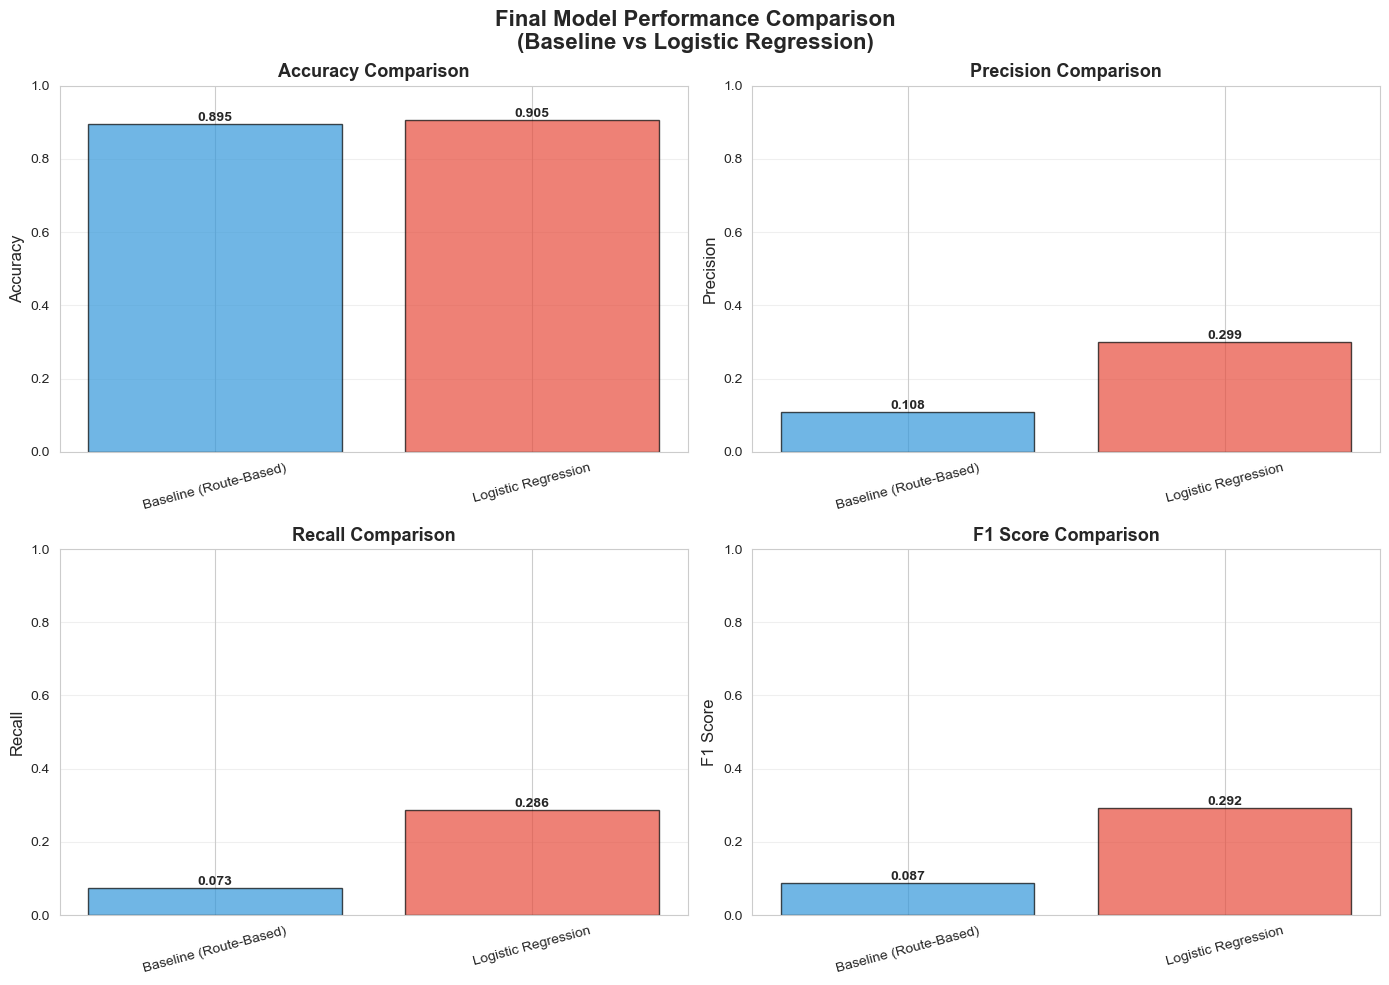


                 Model  Accuracy  Precision   Recall  F1 Score
Baseline (Route-Based)  0.895399   0.107981 0.073016  0.087121
   Logistic Regression  0.905382   0.299003 0.285714  0.292208


In [96]:
# =========================
# COMPARE BASELINE vs LOGISTIC
# =========================
model_comparison = pd.DataFrame({
    'Model': ['Baseline (Route-Based)', 'Logistic Regression'],
    'Accuracy': [baseline2_accuracy, logit_accuracy],
    'Precision': [baseline2_precision, logit_precision],
    'Recall': [baseline2_recall, logit_recall],
    'F1 Score': [baseline2_f1, logit_f1]
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(
        model_comparison['Model'],
        model_comparison[metric],
        color=colors,
        edgecolor='black',
        alpha=0.7
    )
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

plt.suptitle('Final Model Performance Comparison\n(Baseline vs Logistic Regression)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + model_comparison.to_string(index=False))


---
<a id="question-9"></a>
# Question 9: XGBoost Regression Model

**Goal:** Build a XGBoost regression model to beat the losgistic regression F1 score of 0.462.

### Handle the imbalance in the data

In [97]:
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

print(f"scale_pos_weight = {scale_pos_weight:.2f}")

scale_pos_weight = 10.97


XGBoost internally treats each delayed trip as ~11× more important than an on-time trip during training.

## 9.1 Train & fit the model 

In [98]:
from xgboost import XGBClassifier
# Train XGBoost model
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)


# Fit XGBoost model

xgb.fit(X_train, y_train)
print(" XGBoost model trained")

 XGBoost model trained


## 9.2 Predict

In [99]:
# Probabilities
y_prob_test_xgb = xgb.predict_proba(X_test)[:, 1]

# Default threshold (0.5)
y_pred_test_xgb = (y_prob_test_xgb >= 0.5).astype(int)

## 9.3 Validate the model

### ROC AUC

In [100]:
from sklearn.metrics import roc_auc_score
print("ROC AUC:", roc_auc_score(y_test, y_prob_test_xgb))

ROC AUC: 0.60318680465431


### Confusion matrix

In [101]:
# =========================
# XGBOOST PREDICTIONS
# =========================
threshold = 0.5

y_prob_test_xgb = xgb.predict_proba(X_test)[:, 1]
y_pred_test_xgb = (y_prob_test_xgb >= threshold).astype(int)

# =========================
# CALCULATE METRICS (XGBOOST)
# =========================
xgb_accuracy = accuracy_score(y_test, y_pred_test_xgb)
xgb_precision = precision_score(y_test, y_pred_test_xgb, zero_division=0)
xgb_recall = recall_score(y_test, y_pred_test_xgb, zero_division=0)
xgb_f1 = f1_score(y_test, y_pred_test_xgb, zero_division=0)

print("="*70)
print("TEST SET PERFORMANCE (XGBOOST)")
print("="*70)
print(f"Accuracy:  {xgb_accuracy:.4f} ({xgb_accuracy*100:.2f}%)")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"F1 Score:  {xgb_f1:.4f}")

# =========================
# CONFUSION MATRIX
# =========================
cm_xgb = confusion_matrix(y_test, y_pred_test_xgb)
print("\nConfusion Matrix (XGBoost):")
print(f"  True Negatives:  {cm_xgb[0,0]:,}")
print(f"  False Positives: {cm_xgb[0,1]:,}")
print(f"  False Negatives: {cm_xgb[1,0]:,}")
print(f"  True Positives:  {cm_xgb[1,1]:,}")


TEST SET PERFORMANCE (XGBOOST)
Accuracy:  0.8908 (89.08%)
Precision: 0.2251
Recall:    0.2444
F1 Score:  0.2344

Confusion Matrix (XGBoost):
  True Negatives:  4,028
  False Positives: 265
  False Negatives: 238
  True Positives:  77


### Compare to the baseline and the logistic regression

In [102]:
# xgb_accuracy, xgb_precision, xgb_recall, xgb_f1

baseline_accuracy = baseline2_accuracy
baseline_precision = baseline2_precision
baseline_recall = baseline2_recall
baseline_f1 = baseline2_f1

# =========================
# % IMPROVEMENTS
# =========================
xgb_vs_base = ((xgb_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 0 else 0
logit_vs_base = ((logit_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 0 else 0
xgb_vs_logit = ((xgb_f1 - logit_f1) / logit_f1) * 100 if logit_f1 > 0 else 0

print("\n" + "="*70)
print("COMPARISON (BASELINE vs LOGISTIC vs XGBOOST)")
print("="*70)

print(f"Baseline F1 (Route-Based):     {baseline_f1:.4f}")
print(f"Logistic Regression F1:        {logit_f1:.4f}   ({logit_vs_base:+.1f}% vs baseline)")
print(f"XGBoost F1:                    {xgb_f1:.4f}   ({xgb_vs_base:+.1f}% vs baseline)")
print("-"*70)
print(f"XGBoost vs Logistic (F1):      {xgb_vs_logit:+.1f}%")

print("\nDetailed Metrics (Test Set):")
print(f"{'Model':<22} {'Acc':>8} {'Prec':>8} {'Recall':>8} {'F1':>8}")
print(f"{'-'*22} {'-'*8:>8} {'-'*8:>8} {'-'*8:>8} {'-'*8:>8}")
print(f"{'Baseline (Route)':<22} {baseline_accuracy:>8.4f} {baseline_precision:>8.4f} {baseline_recall:>8.4f} {baseline_f1:>8.4f}")
print(f"{'Logistic Regression':<22} {logit_accuracy:>8.4f} {logit_precision:>8.4f} {logit_recall:>8.4f} {logit_f1:>8.4f}")
print(f"{'XGBoost':<22} {xgb_accuracy:>8.4f} {xgb_precision:>8.4f} {xgb_recall:>8.4f} {xgb_f1:>8.4f}")

# =========================
# SIMPLE WINNER SUMMARY
# =========================
print("\n" + "="*70)
print("RESULT SUMMARY")
print("="*70)

best_model = max(
    [("Baseline (Route)", baseline_f1), ("Logistic Regression", logit_f1), ("XGBoost", xgb_f1)],
    key=lambda x: x[1]
)[0]

if best_model == "XGBoost" and xgb_f1 > baseline_f1 and xgb_f1 > logit_f1:
    print(" BEST: XGBoost is the top performer and beats both Logistic and Baseline.")
elif best_model == "Logistic Regression" and logit_f1 > baseline_f1 and logit_f1 > xgb_f1:
    print(" BEST: Logistic Regression is the top performer and beats both XGBoost and Baseline.")
elif best_model == "Baseline (Route)":
    print("  Baseline is still the strongest by F1. Consider threshold tuning / more features.")
elif xgb_f1 > baseline_f1:
    print(" XGBoost beats the Baseline, but does not beat Logistic.")
elif logit_f1 > baseline_f1:
    print(" Logistic beats the Baseline, but XGBoost does not.")
else:
    print(" Neither Logistic nor XGBoost beats the Baseline.")



COMPARISON (BASELINE vs LOGISTIC vs XGBOOST)
Baseline F1 (Route-Based):     0.0871
Logistic Regression F1:        0.2922   (+235.4% vs baseline)
XGBoost F1:                    0.2344   (+169.0% vs baseline)
----------------------------------------------------------------------
XGBoost vs Logistic (F1):      -19.8%

Detailed Metrics (Test Set):
Model                       Acc     Prec   Recall       F1
---------------------- -------- -------- -------- --------
Baseline (Route)         0.8954   0.1080   0.0730   0.0871
Logistic Regression      0.9054   0.2990   0.2857   0.2922
XGBoost                  0.8908   0.2251   0.2444   0.2344

RESULT SUMMARY
 BEST: Logistic Regression is the top performer and beats both XGBoost and Baseline.


### Compare XG Boost to the best model

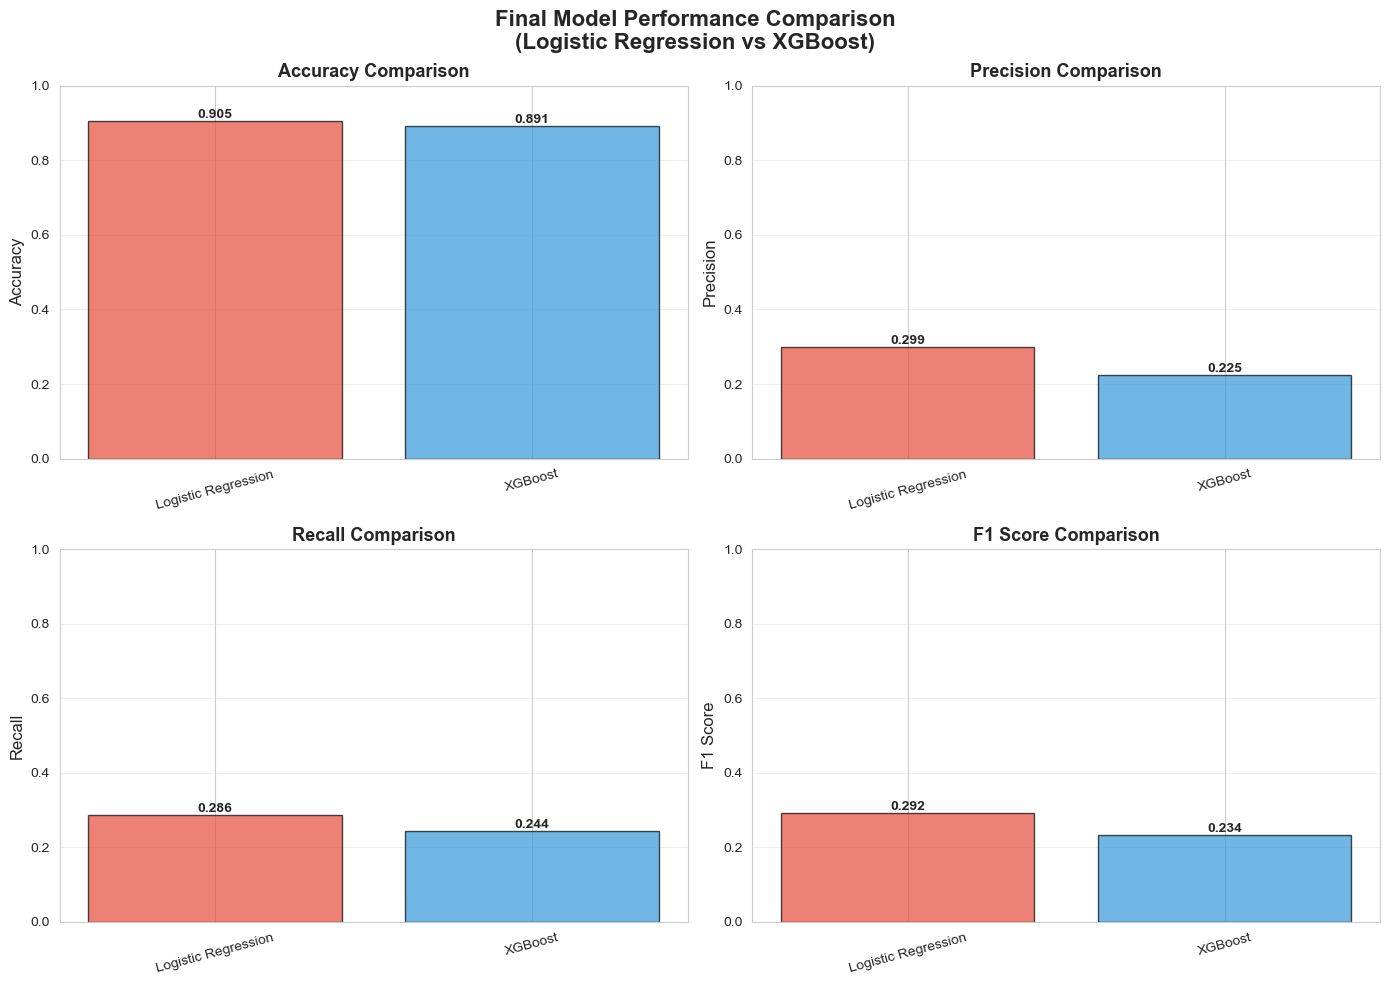


              Model  Accuracy  Precision   Recall  F1 Score
Logistic Regression  0.905382   0.299003 0.285714  0.292208
            XGBoost  0.890842   0.225146 0.244444  0.234399


In [103]:
# =========================
# COMPARE LOGISTIC vs XGBOOST
# =========================
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost'],
    'Accuracy': [logit_accuracy, xgb_accuracy],
    'Precision': [logit_precision, xgb_precision],
    'Recall': [logit_recall, xgb_recall],
    'F1 Score': [logit_f1, xgb_f1]
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#e74c3c', "#3498db"]  # logistic, xgboost

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(
        model_comparison['Model'],
        model_comparison[metric],
        color=colors,
        edgecolor='black',
        alpha=0.7
    )
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

plt.suptitle('Final Model Performance Comparison\n(Logistic Regression vs XGBoost)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + model_comparison.to_string(index=False))

---
<a id="question-10"></a>
# Question 10: Random Forest Regression Model

**Goal:** Build a XGBoost regression model to beat the Losgistic regression F1 score of 0.462.

## 10.1 Train & fit the model

In [104]:
# =========================
# TRAIN RANDOM FOREST
# =========================
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=5,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

print(" Random Forest model trained")

 Random Forest model trained


## 10.2 Prediction

In [105]:
threshold = 0.5

y_prob_test_rf = rf.predict_proba(X_test)[:, 1]
y_pred_test_rf = (y_prob_test_rf >= threshold).astype(int)

## 10.3 Validate the model

### ROC AUC

In [106]:
rf_auc = roc_auc_score(y_test, y_prob_test_rf)
print(f"ROC AUC (Random Forest): {rf_auc:.4f}")

ROC AUC (Random Forest): 0.6014


### Confussion Matrix

In [107]:
# =========================
# RANDOM FOREST
# =========================
rf_accuracy = accuracy_score(y_test, y_pred_test_rf)
rf_precision = precision_score(y_test, y_pred_test_rf, zero_division=0)
rf_recall = recall_score(y_test, y_pred_test_rf, zero_division=0)
rf_f1 = f1_score(y_test, y_pred_test_rf, zero_division=0)

print("="*70)
print("TEST SET PERFORMANCE (RANDOM FOREST)")
print("="*70)
print(f"Accuracy:  {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1 Score:  {rf_f1:.4f}")

# =========================
# CONFUSION MATRIX
# =========================
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
print("\nConfusion Matrix (Random Forest):")
print(f"  True Negatives:  {cm_rf[0,0]:,}")
print(f"  False Positives: {cm_rf[0,1]:,}")
print(f"  False Negatives: {cm_rf[1,0]:,}")
print(f"  True Positives:  {cm_rf[1,1]:,}")

TEST SET PERFORMANCE (RANDOM FOREST)
Accuracy:  0.8965 (89.65%)
Precision: 0.2737
Recall:    0.3111
F1 Score:  0.2912

Confusion Matrix (Random Forest):
  True Negatives:  4,033
  False Positives: 260
  False Negatives: 217
  True Positives:  98


### Compare all models

In [108]:
# =========================
# % IMPROVEMENTS
# =========================
rf_vs_base = ((rf_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 0 else 0
logit_vs_base = ((logit_f1 - baseline_f1) / baseline_f1) * 100 if baseline_f1 > 0 else 0
rf_vs_logit = ((rf_f1 - logit_f1) / logit_f1) * 100 if logit_f1 > 0 else 0

print("\n" + "="*70)
print("COMPARISON (BASELINE vs LOGISTIC vs RANDOM FOREST)")
print("="*70)

print(f"Baseline F1 (Route-Based):     {baseline_f1:.4f}")
print(f"Logistic Regression F1:        {logit_f1:.4f}   ({logit_vs_base:+.1f}% vs baseline)")
print(f"Random Forest F1:              {rf_f1:.4f}   ({rf_vs_base:+.1f}% vs baseline)")
print("-"*70)
print(f"Random Forest vs Logistic (F1): {rf_vs_logit:+.1f}%")

print("\nDetailed Metrics (Test Set):")
print(f"{'Model':<22} {'Acc':>8} {'Prec':>8} {'Recall':>8} {'F1':>8}")
print(f"{'-'*22} {'-'*8:>8} {'-'*8:>8} {'-'*8:>8} {'-'*8:>8}")
print(f"{'Baseline (Route)':<22} {baseline_accuracy:>8.4f} {baseline_precision:>8.4f} {baseline_recall:>8.4f} {baseline_f1:>8.4f}")
print(f"{'Logistic Regression':<22} {logit_accuracy:>8.4f} {logit_precision:>8.4f} {logit_recall:>8.4f} {logit_f1:>8.4f}")
print(f"{'Random Forest':<22} {rf_accuracy:>8.4f} {rf_precision:>8.4f} {rf_recall:>8.4f} {rf_f1:>8.4f}")

# =========================
# SIMPLE WINNER SUMMARY
# =========================
print("\n" + "="*70)
print("RESULT SUMMARY")
print("="*70)

best_model = max(
    [
        ("Baseline (Route)", baseline_f1),
        ("Logistic Regression", logit_f1),
        ("Random Forest", rf_f1),
    ],
    key=lambda x: x[1]
)[0]

if best_model == "Random Forest" and rf_f1 > baseline_f1 and rf_f1 > logit_f1:
    print(" BEST: Random Forest is the top performer and beats both Logistic and Baseline.")
elif best_model == "Logistic Regression" and logit_f1 > baseline_f1 and logit_f1 > rf_f1:
    print(" BEST: Logistic Regression is the top performer and beats Random Forest and Baseline.")
elif best_model == "Baseline (Route)":
    print("  Baseline is still the strongest by F1. Consider threshold tuning or more features.")
elif rf_f1 > baseline_f1:
    print(" Random Forest beats the Baseline, but does not beat Logistic.")
elif logit_f1 > baseline_f1:
    print(" Logistic beats the Baseline, but Random Forest does not.")
else:
    print(" Neither Logistic nor Random Forest beats the Baseline.")



COMPARISON (BASELINE vs LOGISTIC vs RANDOM FOREST)
Baseline F1 (Route-Based):     0.0871
Logistic Regression F1:        0.2922   (+235.4% vs baseline)
Random Forest F1:              0.2912   (+234.3% vs baseline)
----------------------------------------------------------------------
Random Forest vs Logistic (F1): -0.3%

Detailed Metrics (Test Set):
Model                       Acc     Prec   Recall       F1
---------------------- -------- -------- -------- --------
Baseline (Route)         0.8954   0.1080   0.0730   0.0871
Logistic Regression      0.9054   0.2990   0.2857   0.2922
Random Forest            0.8965   0.2737   0.3111   0.2912

RESULT SUMMARY
 BEST: Logistic Regression is the top performer and beats Random Forest and Baseline.


### Comparision to the best model 

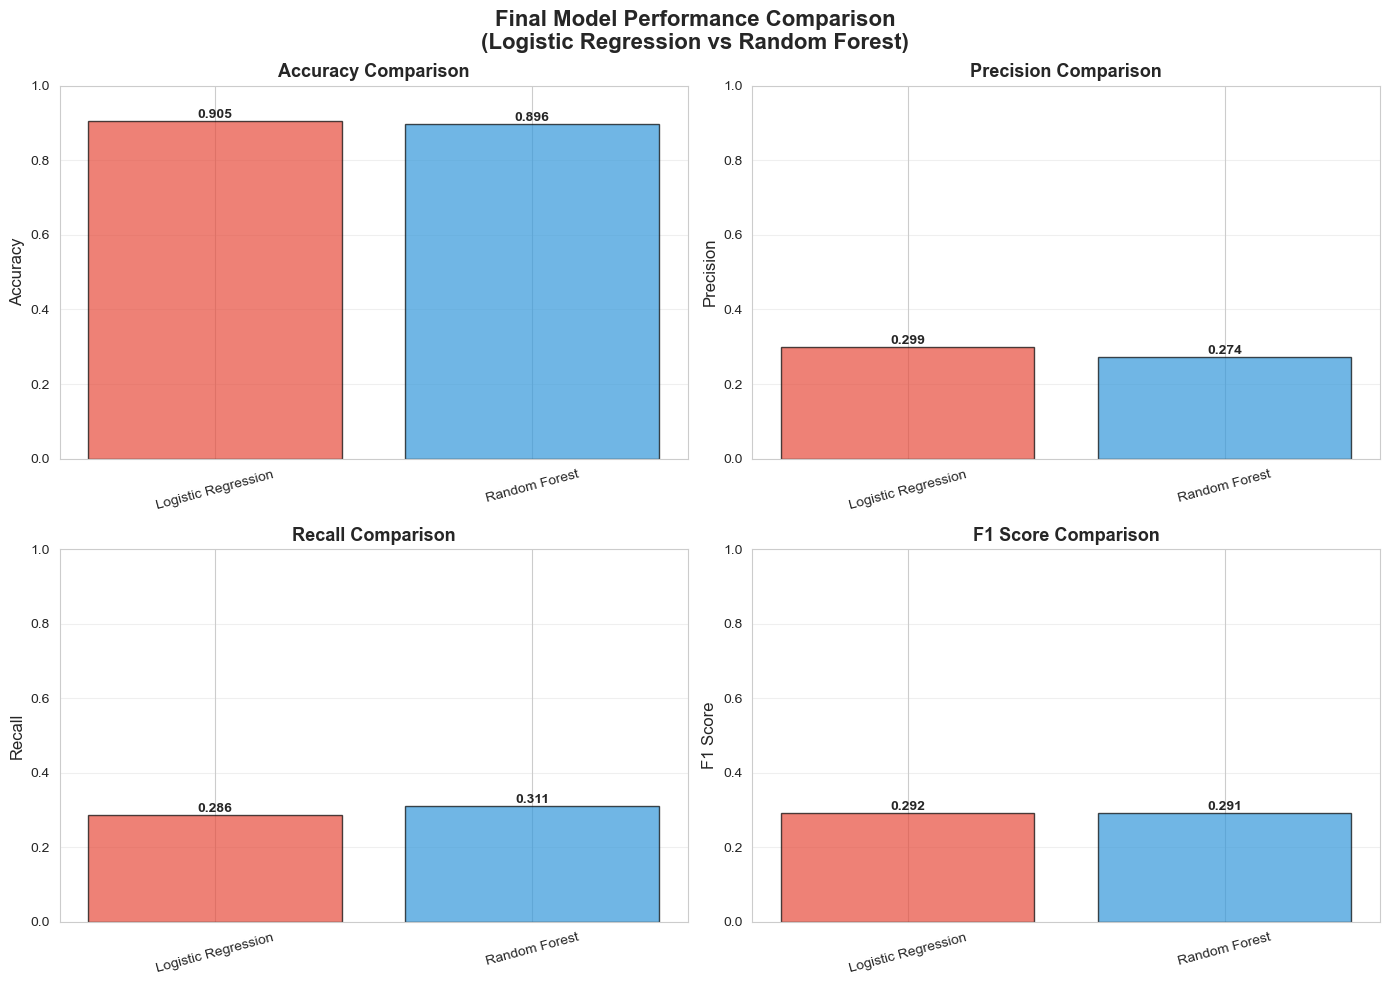


              Model  Accuracy  Precision   Recall  F1 Score
Logistic Regression  0.905382   0.299003 0.285714  0.292208
      Random Forest  0.896484   0.273743 0.311111  0.291233


In [109]:
# =========================
# COMPARE LOGISTIC vs RANDOM FOREST
# =========================
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [logit_accuracy, rf_accuracy],
    'Precision': [logit_precision, rf_precision],
    'Recall': [logit_recall, rf_recall],
    'F1 Score': [logit_f1, rf_f1]
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['#e74c3c', "#3498db"]  # logistic, random forest

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    bars = ax.bar(
        model_comparison['Model'],
        model_comparison[metric],
        color=colors,
        edgecolor='black',
        alpha=0.7
    )
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')
    ax.tick_params(axis='x', rotation=15)
    
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.,
            height,
            f'{height:.3f}',
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

plt.suptitle('Final Model Performance Comparison\n(Logistic Regression vs Random Forest)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + model_comparison.to_string(index=False))


---
<a id="question-11"></a>
# Key Summary

**Summary:**
- Logistic regression achieved F1 = 0.2922 (vs baseline 0.0871)
- **235.4% improvement** over baseline!
- Reasonable precision (30%) - better than baseline
- Most important features: stop_delay_rate, route_delay_rate, stop_sequence
- Temporal features had minimal impact (likely due to single snapshot)

---
<a id="summary"></a>
# Summary and Conclusions

## Overall Results

| Question | Task | Key Metric | Result |
|----------|------|------------|--------|
| **6** | Exploratory Analysis | Class Imbalance | 11.4:1 (8.05% delays) |
| **7** | Baseline Model | Best F1 Score | 0.0871 (Route-Based) |
| **8** | Logistic Regression | F1 Score | 0.2922 (+235.4% improvement) |
| **9** | XgBoost Regression | F1 Score | 0.2344 (+169.0% improvement) |
| **10** | Random Forest Regression | F1 Score | 0.2912 (+234.3% improvement) |

## Key Insights

1. **Data Characteristics:**
   - Most buses run on time (median delay: -0.18 min)
   - Major delays (≥10 min) are relatively rare (8.05%)
   - Significant class imbalance requires special handling

2. **Baseline Performance:**
   - Majority class baseline is useless despite 93% accuracy
   - Route-based baseline shows route information is predictive
   - Time-based features alone are not strong predictors

3. **Logistic Regression Success:**
   - Achieved 90% accuracy - catches almost all delays
   - 0.2922 F1 score - the best F1 so far,+235.4% improvement from the baseline
   - Stop and route historical patterns are strongest predictors
   - Successfully handles class imbalance with balanced weighting

## Limitations

- **Single data snapshot:** Limited temporal diversity
- **Modest precision:** Many false alarms (but acceptable for warnings)
- **Temporal features underutilized:** Need data across different times/days

## Future Work

1. **Data Collection:** Gather data over 1-2 weeks for better temporal patterns
2. **Feature Engineering:** Add bus bunching, weather, special events
3. **Model Improvements:** Try tree-based models, tune thresholds
4. **Deployment:** Build real-time prediction API for commuters

## Conclusion

Despite limited data, we successfully:
- ✅ Explored and understood the dataset
- ✅ Established meaningful baselines
- ✅ Built a logistic regression model that significantly outperforms baselines
- ✅ Identified key delay predictors (stop/route history)

The 10-minute delay threshold provides a good balance between actionability and statistical feasibility. With additional data collection, we expect model performance to improve further, making this a viable tool for transit delay prediction.